## Multi Category Classifcation

In [1]:

import os
import numpy as np

In [2]:
! pip install -Uqq fastbook
import fastbook
from fastbook import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = get_x, get_y = get_y
)

In [6]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [7]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['car','person']

In [8]:
# define what goes in the validation set
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x,
                  get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

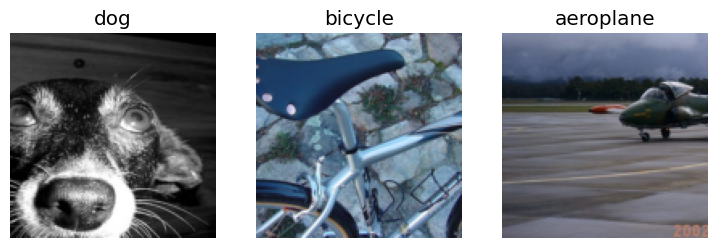

In [9]:
# create a dataloader right now
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [10]:
learn = vision_learner(dls, resnet18)
x,y = to_cpu(dls.train.one_batch()) # also moves data to cpu
activs = learn.model(x)
activs.shape

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.0MB/s]


torch.Size([64, 20])

In [11]:
# the loss function will be binary cross entropy
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

'''
Equivalent in Pytorch are:
1. F.binary_cross_entropy_with_logits
2. nn.BCEWithLogitsLoss
'''



'\nEquivalent in Pytorch are:\n1. F.binary_cross_entropy_with_logits\n2. nn.BCEWithLogitsLoss\n'

In [12]:
# multi category loss function
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp.sigmoid()
    
    return ((inp>thresh)==targ.bool()).float().mean()

In [13]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.1MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947607,0.695108,0.684183,00:29
1,0.826541,0.563682,0.784283,00:25
2,0.610614,0.209051,0.951932,00:25
3,0.363729,0.125721,0.957092,00:24


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135553,0.118612,0.958127,00:26
1,0.119976,0.107530,0.961912,00:26
2,0.099397,0.103669,0.963446,00:26


## Image Regression to Find Coordinates for Center of Face

In [14]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [16]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
cal = np.genfromtxt(path/'01/rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

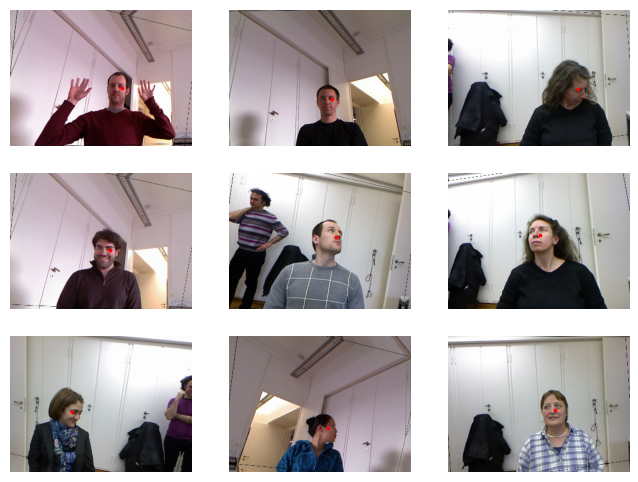

In [17]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320))
)

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.002511886414140463)

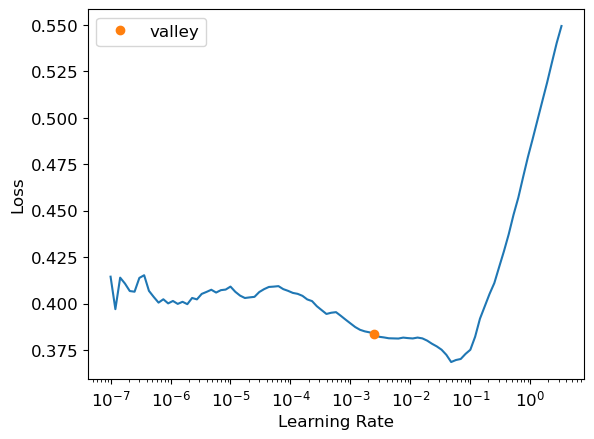

In [18]:
# train the model
learn = vision_learner(dls, resnet18, y_range=(-1, 1))

# find a good learning rate
learn.lr_find()

In [20]:
lr = 1e-3
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.217190,0.015662,02:04


epoch,train_loss,valid_loss,time
0,0.075258,0.004831,02:00
1,0.015828,0.003535,02:02
2,0.008691,0.001981,02:02


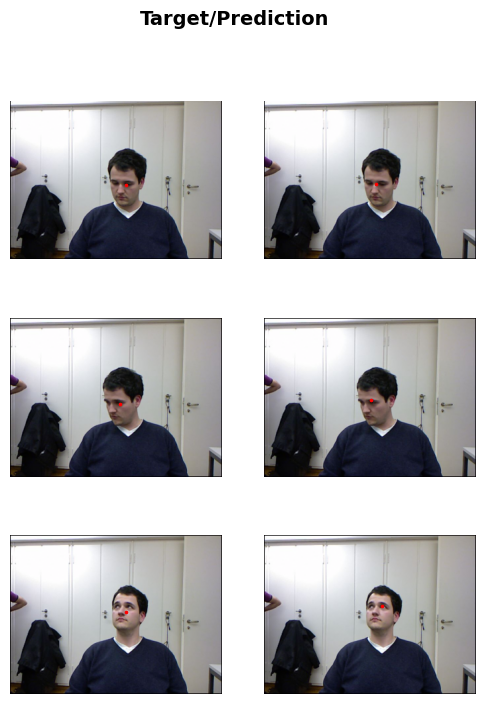

In [21]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))